### Transition Model

In [69]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random

import warnings
warnings.filterwarnings("ignore")

In [70]:
path = os.path.dirname(os.getcwd())
print(path)

C:\Users\shinki\OneDrive - Novelis Inc\Documents\Data Science\10. Learning\7b. Use Case


In [72]:
data = pd.read_pickle(path + '\\Data\\airgas_sample_for_RNF2.pickle')
print(data['Batch'].nunique())
data.rename(columns={'Air_gas_ratio_pv':'airgas_ratio', 'Total 장입량': 'input_total'}, inplace=True) # 컬럼이름 변경
data['time'] = pd.to_datetime(data['Time_9hour'], errors='raise') # Datetime 으로 변경
data.set_index('time', inplace=True)
data.head()

3827


,Batch,after_20min,skimm_start_time,Time_9hour,melting_cycle,skimm_time,airgas_ratio,inner_temp_pv,pre_heated_air_temp,inner_press_pv,Melter,ALLOY,input_total,Prime,Scrap,R S I,molten(%)
time,,,,,,,,,,,,,,,,,
2020-12-01 10:25:19,S49135,2020-12-01 10:25:19.000000,2020-12-01 11:53:19.000000,2020-12-01 10:25:19.000000,20,0,13.15,848.32,144.76,7.62,Melter_4,K3104,"27,350.00",0.00,"18,350.00","2,000.00",25.59
2020-12-01 10:26:19,S49135,2020-12-01 10:25:19.000000,2020-12-01 11:53:19.000000,2020-12-01 10:26:19.000000,21,0,13.06,850.83,145.58,6.59,Melter_4,K3104,"27,350.00",0.00,"18,350.00","2,000.00",25.59
2020-12-01 10:27:19,S49135,2020-12-01 10:25:19.000000,2020-12-01 11:53:19.000000,2020-12-01 10:27:19.000000,22,0,13.10,856.76,146.34,6.71,Melter_4,K3104,"27,350.00",0.00,"18,350.00","2,000.00",25.59
2020-12-01 10:28:19,S49135,2020-12-01 10:25:19.000000,2020-12-01 11:53:19.000000,2020-12-01 10:28:19.000000,23,0,13.12,862.79,147.02,7.13,Melter_4,K3104,"27,350.00",0.00,"18,350.00","2,000.00",25.59
2020-12-01 10:29:19,S49135,2020-12-01 10:25:19.000000,2020-12-01 11:53:19.000000,2020-12-01 10:29:19.000000,24,0,12.98,868.74,148.16,2.78,Melter_4,K3104,"27,350.00",0.00,"18,350.00","2,000.00",25.59


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 320672 entries, 2020-12-01 10:25:19 to 2021-08-31 22:41:01
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Batch                320672 non-null  object 
 1   after_20min          320672 non-null  object 
 2   skimm_start_time     320672 non-null  object 
 3   Time_9hour           320672 non-null  object 
 4   melting_cycle        320672 non-null  int64  
 5   skimm_time           320672 non-null  int64  
 6   airgas_ratio         320672 non-null  float64
 7   inner_temp_pv        320672 non-null  float64
 8   pre_heated_air_temp  320672 non-null  float64
 9   inner_press_pv       320672 non-null  float64
 10  Melter               312673 non-null  object 
 11  ALLOY                312673 non-null  object 
 12  input_total          312673 non-null  float64
 13  Prime                312673 non-null  float64
 14  Scrap                312673 non-nu

In [103]:
data2 =  data[data['inner_temp_pv'].between(750,950) & (data['Melter']=='Melter_3')] # 멜터 3번만 - 시그널 비교적 안정적
# 헌팅을 최소화하기 위해 5분간격 데이터로 변경 - 비어있는 셀이 발생함 나중에 fillna 로 처리. 이렇게 하면 배치 시간의 이중 인덱스로 됨 
summary = data2.groupby('Batch').resample('3Min')[['input_total','molten(%)','airgas_ratio','pre_heated_air_temp','inner_press_pv','inner_temp_pv']].median()

summary.sort_index(inplace=True)
summary.fillna(method='ffill', inplace=True) # 혹시나 빈셀 채워넣음
summary.reset_index('time', inplace=True) # 시간 인덱스는 드롭됨 

summary['count'] = summary.groupby('Batch').size() # 배치별 길이를 만듦
print(summary['count'].describe(percentiles=[0.05, 0.1, 0.15, 0.85, 0.9, 0.95]))
summary2 = summary[summary['count'].between(9, 18)] # 너무 짧거나 긴 배치는 제외

c1 = summary2.groupby('Batch')['inner_temp_pv'].first().between(740, 780)
c2 = summary2.groupby('Batch')['inner_temp_pv'].last().between(930, 970) # 스키밍 시작 전에 끊어야 함

summary3 = summary2.loc[c1[c1&c2].index] # 시작온도랑 끝온도가 비슷한 배치만 고름

count   21,642.00
mean        13.43
std          5.26
min          1.00
5%           7.00
10%          8.00
15%          9.00
50%         13.00
85%         17.00
90%         19.00
95%         25.00
max         37.00
Name: count, dtype: float64


In [104]:
summary3.groupby('Batch')['inner_temp_pv'].first().describe()

count   852.00
mean    759.78
std       7.59
min     750.04
25%     754.21
50%     757.31
75%     763.53
max     779.89
Name: inner_temp_pv, dtype: float64

In [105]:
# 리워드 값을 만들기 위한 데이터 처리
summary3['temp_maxmin'] = summary3.groupby('Batch')['inner_temp_pv'].transform(lambda x: x.tail(1) - x.head(1))
summary3['time_maxmin'] = summary3.groupby('Batch')['time'].transform(lambda x: x.tail(1) - x.head(1)).dt.total_seconds()/60

summary3['input_hard'] = (summary3['input_total']*(1 - summary3['molten(%)']/100))/1000

pd.options.display.float_format = "{:,.2f}".format
summary3['perf'] = (summary3['temp_maxmin']/summary3['time_maxmin'])
summary3['perf'].describe()

count   10,874.00
mean         5.24
std          1.00
min          3.29
25%          4.45
50%          5.19
75%          5.88
max          7.93
Name: perf, dtype: float64

In [77]:
summary3['time_maxmin'].describe()

count   10,874.00
mean        36.51
std          6.99
min         24.00
25%         30.00
50%         36.00
75%         42.00
max         51.00
Name: time_maxmin, dtype: float64

In [106]:
ranks = pd.qcut(summary3['airgas_ratio'], q=5)
print(summary3.groupby(ranks)['airgas_ratio'].agg(['min', 'max']))

def div_a(x):
    if x < 11.6:
        return 0    
    elif x < 12.4:        
        return 1
    elif x < 12.7:        
        return 2
    elif x < 12.9:        
        return 3
    else:
        return 4
    
summary3['action'] = summary3['airgas_ratio'].apply(div_a)
# summary3['action'] = pd.qcut(summary3['airgas_ratio'], q=5, labels=range(5)).astype('int')
print(summary3['action'].value_counts().sort_index())

                    min    max
airgas_ratio                  
(-5.549, 11.551]  -5.55  11.55
(11.551, 12.371]  11.55  12.37
(12.371, 12.734]  12.38  12.73
(12.734, 12.786]  12.73  12.79
(12.786, 671.621] 12.79 671.62
0    3347
1    1020
2     991
3    4444
4    1072
Name: action, dtype: int64


In [48]:
print(summary3.groupby('Batch')['temp_maxmin'].max().describe(percentiles=[0.01, 0.05, 0.95]))
print(summary3.groupby('Batch')['time_maxmin'].max().describe(percentiles=[0.01, 0.05, 0.95]))

count   852.00
mean    184.33
std       8.40
min     159.19
1%      163.12
5%      167.86
50%     186.11
95%     195.24
max     199.16
Name: temp_maxmin, dtype: float64
count   852.00
mean     35.29
std       6.84
min      24.00
1%       24.00
5%       27.00
50%      36.00
95%      48.00
max      51.00
Name: time_maxmin, dtype: float64


In [107]:
ranks = pd.qcut(summary3['perf'], q = 5)
summary3.groupby(ranks)['action'].mean()
# > Performance 좋은 경우는 일반적으로 공연비 낮게 설정???

perf
(3.291, 4.302]   2.27
(4.302, 4.896]   2.15
(4.896, 5.467]   1.75
(5.467, 6.136]   1.60
(6.136, 7.93]    1.70
Name: action, dtype: float64

In [50]:
summary3[summary3['perf']>7.2].index.unique()

Index(['S49349-1', 'S49351-1', 'S49352-1', 'S49674-1', 'S50178-1', 'S51382-1',
       'S51509-1', 'S51516-1', 'S51637-1', 'S51697-1', 'S52151-1', 'S52591-1',
       'S54318-1', 'S57551-1', 'S57553-1', 'S57655-1', 'S57719-1', 'S58327-1',
       'S59094-1', 'S59269-1', 'S59415-1', 'S60086-1', 'S60093-1', 'S60531-1',
       'S60585-1', 'S61400-1', 'S61778-1', 'S62045-1', 'S62227-1', 'S62438-1',
       'S62536-1', 'S62730-1', 'S62731-1', 'S62742-1', 'S62854-1', 'S62855-1',
       'S62858-1', 'S63043-1'],
      dtype='object', name='Batch')

In [83]:
summary3[summary3['perf']<3.5].index.unique()

Index(['S53898-1', 'S56848-1', 'S57011-1', 'S57096-1', 'S57097-1', 'S57812-1',
       'S59177-1', 'S59863-1', 'S60319-1'],
      dtype='object', name='Batch')

lapse time(min) to reach 950 :  50


[]

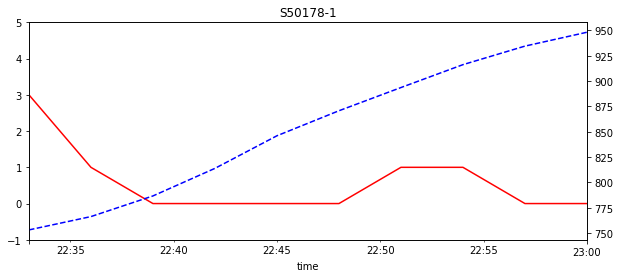

In [82]:
# batch = summary2.sample(1).index.values[0]
batch = 'S50178-1'

sample = summary3[summary3.index.isin([batch])].set_index('time')
print('lapse time(min) to reach 950 : ', len(sample)*5)

#var = 'preheat_dif'
var = 'inner_temp_pv'

ax = sample['action'].plot(color='red', figsize=(10,4) )
ax2 = ax.twinx()
ax2 = sample[var].plot(color='blue', style='--', figsize=(10,4))
plt.title(str(batch))
ax.set_label('airgas ratio')
ax2.set_label('inner temp')
ax.set_ylim(-1,5)
plt.plot()

lapse time(min) to reach 950 :  90


[]

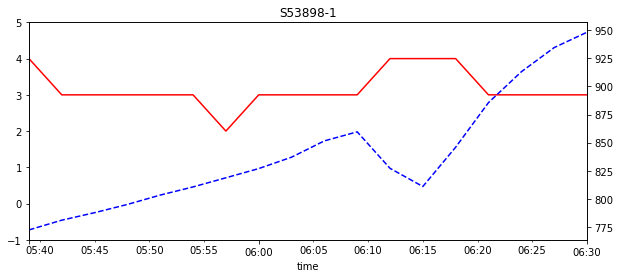

In [85]:
# batch = summary2.sample(1).index.values[0]
batch = 'S53898-1'

sample = summary3[summary3.index.isin([batch])].set_index('time')
print('lapse time(min) to reach 950 : ', len(sample)*5)

#var = 'preheat_dif'
var = 'inner_temp_pv'

ax = sample['action'].plot(color='red', figsize=(10,4) )
ax2 = ax.twinx()
ax2 = sample[var].plot(color='blue', style='--', figsize=(10,4))
plt.title(str(batch))
ax.set_label('airgas ratio')
ax2.set_label('inner temp')
ax.set_ylim(-1,5)
plt.plot()

- ### Transition Function

In [108]:
pd.options.display.float_format = "{:,.2f}".format
input_data = summary3[['input_hard','pre_heated_air_temp','inner_press_pv','inner_temp_pv','airgas_ratio','action','time']]
len(input_data)

10874

In [109]:
# Create target features (delta)
input_data['preheat_delta'] = input_data.groupby('Batch')['pre_heated_air_temp'].transform(lambda x: x.shift(-1) - x)
input_data['temp_delta'] = input_data.groupby('Batch')['inner_temp_pv'].transform(lambda x: x.shift(-1) - x)
input_data['pressure_delta'] = input_data.groupby('Batch')['inner_press_pv'].transform(lambda x: x.shift(-1) - x)
input_data.dropna(inplace=True)

# Create X

from sklearn import preprocessing
input_features = ['pre_heated_air_temp','inner_press_pv', 'inner_temp_pv', 'input_hard', 'action']
output_features = ['preheat_delta','pressure_delta','temp_delta']
feature_list = input_features + output_features

X_scaler = preprocessing.StandardScaler()
Y_scaler = preprocessing.StandardScaler()
X_std = X_scaler.fit_transform(input_data[input_features])
Y_std = Y_scaler.fit_transform(input_data[output_features])


In [110]:
with open("x_scaler", "wb") as file:
    pickle.dump(X_scaler, file)
    
with open("y_scaler", "wb") as file:
    pickle.dump(Y_scaler, file)    

In [111]:
with open('x_scaler', 'rb') as file:
    X_scaler = pickle.load(file)
    
with open('y_scaler', 'rb') as file:
    Y_scaler = pickle.load(file)    

In [112]:
input_data[['pre_heated_air_temp','inner_press_pv', 'inner_temp_pv', 'input_hard', 'action','time']].head()
input_data.to_pickle('input_data.pkl')

In [113]:
print(X_std.shape, Y_std.shape)

(10022, 5) (10022, 3)


In [114]:
np.hstack((X_std, Y_std)).shape

(10022, 8)

In [115]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.nn.init as init

from torch.utils.data import DataLoader, Dataset 

In [116]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 128)   
        self.fc3 = nn.Linear(128, 3)
        self.dropout_prob = 0.3
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(128)        

    def forward(self, x): 
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)        
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)                               
        
        x = self.fc3(x)
        return x

In [117]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform(m.weight.data)

model = Net()
model.apply(weight_init)


class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

trainsets = TensorData(X_std, Y_std)    
trainloader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle = True, drop_last=True)


LEARNING_RATE = 0.0005
loss_list = [] # loss를 저장할 리스트.
n = len(trainloader)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE ) 

for epoch in range(1000):

    running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화.

        outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
        loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
        loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
        optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

        loss_list.append(running_loss/n) # MSE(Mean Squared Error) 계산                

    
    if epoch % 100 == 0:
        print(f'{epoch: 5d} : { pd.Series(loss_list).tail(10).mean(): 5.4f}')
        
    if (running_loss/n) < 0.7:
        break        


    0 :  1.3721
  100 :  0.7159
  200 :  0.7042
  300 :  0.7017
  400 :  0.7030
  500 :  0.7000
  600 :  0.6994


In [119]:
# Save the final model
# torch.save(model.state_dict(), 'transition.pt')
model_weights = torch.load('transition.pt')
model = Net()
model.load_state_dict(model_weights)
model.eval()

Net(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [120]:
X = torch.FloatTensor(X_std[:1])
print(X.shape)
model(X)

torch.Size([1, 5])


tensor([[-1.4875, -0.2250,  0.0448]], grad_fn=<AddmmBackward0>)

In [121]:
Y_std[:1]


array([[-1.6815876 , -0.82177235,  0.98917303]])

In [122]:
# Gausian noise
s = np.random.normal(0, 0.2, 10000)
pd.Series(s).mean()

0.0022746571348547886

In [123]:
input_data[input_features].head(10)

,pre_heated_air_temp,inner_press_pv,inner_temp_pv,input_hard,action
Batch,,,,,
S49137-1,166.88,7.84,777.04,18.00,4
S49137-1,165.70,5.99,799.60,18.00,0
S49137-1,166.58,7.43,818.94,18.00,0
S49137-1,168.99,9.48,839.72,18.00,0
S49137-1,172.08,6.29,854.13,18.00,0
S49137-1,174.57,0.82,866.20,18.00,4
S49137-1,177.88,3.69,867.75,18.00,1
S49137-1,180.84,4.71,895.07,18.00,0
S49137-1,184.70,4.91,916.80,18.00,1


In [124]:
from sklearn import preprocessing
X_test = np.array(input_data[input_features][:1])
print(X_test)

X_test[0][4] = 0

cnt = 0
while True:
    cnt += 1
    Yhat = model(torch.FloatTensor(X_scaler.transform(X_test)))
    delta = Y_scaler.inverse_transform(Yhat.detach().numpy())
    delta = np.append(delta, [[0, 0]])
    X_test = pd.DataFrame(np.array(X_test) + (delta))
    print(cnt, np.array(X_test).flatten())
    if X_test[2].item()>950:
        
        break
        
# print(np.array(X_test))
# print('\n')
# print(np.array(X_test.add(delta)))

# scaler = preprocessing.StandardScaler()
# X_std = scaler.fit_transform(input_data[input_features])
# Y_std = scaler.fit_transform(input_data[output_features])


[[166.8847961    7.83920145 777.0363159   18.           4.        ]]
1 [168.18447073   7.15409458 792.34469603  18.           0.        ]
2 [169.78311248   6.53523385 808.12594126  18.           0.        ]
3 [171.71765919   5.9895013  824.0921192   18.           0.        ]
4 [174.04246469   5.45498854 840.30488585  18.           0.        ]
5 [176.70605536   4.94249201 856.70104597  18.           0.        ]
6 [179.71902056   4.49866345 873.1588764   18.           0.        ]
7 [183.23974963   4.1555537  889.72469137  18.           0.        ]
8 [187.08798953   3.88659203 906.30276869  18.           0.        ]
9 [191.06995721   3.67631128 922.6735153   18.           0.        ]
10 [195.103157     3.51769954 938.47699354  18.           0.        ]
11 [198.89212342   3.22270644 950.44269274  18.           0.        ]
